In [1]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from pykrige.kriging_tools import write_asc_grid
import pykrige.kriging_tools as kt
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Path, PathPatch

In [42]:
def plot_ei(df,path_to_rep,species,date):
    df = df.dropna(axis = 0, how="any")
    lons = np.array(df.long)
    lats = np.array(df.lat)
    data = np.array(df.EI)
    grid_space = 0.1
    grid_lon = np.arange(lons.min()-0.05, lons.max()+0.1, grid_space) 
    grid_lat = np.arange(lats.min()-0.05, lats.max()+0.1, grid_space)
    OK = OrdinaryKriging(lons, lats, data, variogram_model='gaussian', verbose=True, enable_plotting=False,nlags=20)
    z1, ss1 = OK.execute('grid', grid_lon, grid_lat)
    xintrp, yintrp = np.meshgrid(grid_lon, grid_lat)
    
    ind = (z1>1)
    z1[ind] = 1
    ind = (z1<0)
    z1[ind] = 0
    
    fig, ax = plt.subplots(figsize=(10,10))
    m = Basemap(llcrnrlon=119.5,llcrnrlat=21.5,
                urcrnrlon=122.5,urcrnrlat=26, projection='merc', 
                resolution='h',area_thresh=1000.,ax=ax)
    m.drawcoastlines() #draw coastlines on the map
    x,y=m(xintrp,yintrp)
    lo,la = m(lons,lats)
    cs = ax.contourf(x,y,z1,
                       cmap="rainbow",
                       levels = np.linspace(0,1,10))
    #cs = ax.scatter(lo,la,c=data,cmap="rainbow")
    ax.scatter(lo,la,c=data,cmap="rainbow",vmin=0,vmax=1,edgecolor="k")
    cbar=m.colorbar(cs,location='right') #plot the colorbar on the map
    parallels = np.arange(21.5,26.0,1)
    m.drawparallels(parallels,labels=[1,0,0,0],fontsize=14, linewidth=0.0) #Draw the latitude labels on the map
    meridians = np.arange(119.5,123.5,1)
    m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=14, linewidth=0.0)

    x0,x1 = ax.get_xlim()
    y0,y1 = ax.get_ylim()
    map_edges = np.array([[x0,y0],[x1,y0],[x1,y1],[x0,y1]])
    polys = [p.boundary for p in m.landpolygons]
    polys = [map_edges]+polys[:]
    codes = [
    [Path.MOVETO]+[Path.LINETO for p in p[1:]]
    for p in polys
    ]

    polys_lin = [v for p in polys for v in p]
    codes_lin = [c for cs in codes for c in cs]

    path = Path(polys_lin, codes_lin)
    patch = PathPatch(path,facecolor='white', lw=0)
    ax.add_patch(patch)
#    plt.title("EI at {}".format(date))
    plt.savefig(path_to_rep + "result/{}_{}.png".format(species,date),bbox_inches="tight",dpi=300)

In [63]:
def digit00(x):
    if x < 10:
        return '0' + str(x)
    else:
        return str(x) 


def get_mi(prec,sm):
    shp = prec.shape
    mi = np.zeros(shp,dtype=np.float)

    for i in range(shp[0]):
        m = prec[i]
        if m < sm[0]:
            mi_index = 0
        elif m < sm[1]:
            mi_index = (m - sm[0])/(sm[1] - sm[0])
        elif m < sm[2]:
            mi_index = 1.
        elif m < sm[3]:
            mi_index = (m - sm[3])/(sm[2] - sm[3])
        else:
            mi_index = 0.
        mi[i] = mi_index

    return mi

def get_ti(td,tn,dv):
    shp = td.shape
    ti = np.zeros(shp,dtype=np.float)

    for i in range(shp[0]):
        hi_temp = td[i]
        low_temp = tn[i]
        dt = hi_temp - low_temp
        if dt > 0:
            iq = min( 1, 12 * max(0, hi_temp - dv[0]) ** 2 / dt / ((dv[1] - dv[0]) * 24))
        else:
            iq = np.nan
        ih = min( 1 - ( max(0, hi_temp - dv[2]) / (dv[3] - dv[2])) , 1)
        ti[i] = iq * ih
    return ti

def get_ei(path_to_rep,species,date):

  path_to_data = path_to_rep + 'analysis/'

  data_temp_max = pd.read_csv(path_to_data+'tmax.csv',encoding="UTF-8")
  data_temp_min = pd.read_csv(path_to_data+'tmin.csv',encoding="UTF-8")
  data_precp = pd.read_csv(path_to_data+'precp.csv',encoding="UTF-8")
  data_species = pd.read_csv(path_to_rep+'species.csv',encoding="UTF-8")

#  station_id = data_temp_max['id']
  temp_max = data_temp_max[['name',date]]
  temp_min = data_temp_min[['name',date]]
  precp = data_precp[['name',date]]

  ind = (data_species['scientific_name'] == species)
  sm, dv = np.zeros(4), np.zeros(4)
  for i in range(4):
    key = 'sm_' + '%1.1d' % i
    sm[i] =  data_species[key][ind]
    key = 'dv_' + '%1.1d' % i
    dv[i] =  data_species[key][ind]

  raw_data = temp_max.merge(temp_min,left_on='name',right_on='name')
  raw_data = raw_data.merge(precp,left_on='name',right_on='name')

  param = {}
  name = np.array(raw_data['name'])
  tmax = np.array(raw_data[date+'_x'])
  tmin = np.array(raw_data[date+'_y'])
  precp = np.array(raw_data[date])
  ind = (tmax>=-100) * (tmin>=-100) * (precp>=-100)

  name = name[ind]
  tmax = tmax[ind]
  tmin = tmin[ind]
  precp = precp[ind]

  ei = np.zeros(name.shape[0])

  ti = get_ti(tmax,tmin,dv)
  mi = get_mi(precp,sm)

  ei = ti * mi

#  for i in range(ei.shape[0]):
#    print ('%s %6.2f %6.2f %6.2f' %(name[i],ei[i],tmax[i],precp[i]))

  return name, ei

def run_ei(path_to_rep,species,date):
    name, ei = get_ei(path_to_rep,species,date)
    sta = pd.read_csv("../CWB_Stations_171226.csv")
    sta = sta[['id','long','lat']]
    eidt=pd.DataFrame(data={a:b for a,b in zip(name,ei)},index=['EI']).T
    eidt = eidt.merge(sta, left_index=True, right_on='id')
    return eidt



def main():
    global name
    global ei

#    date = '2017-02'
    path_to_rep = "../"
    species = 'solenopsis_invicta'
    for yy in range(2010,2018):
        for mm in range(1,13):
            date = "{}-{}".format(yy,digit00(mm))
            print(date)
    #            str         str      

            name, ei = get_ei(path_to_rep,species,date)
            eidt = run_ei(path_to_rep,species,date)
            plot_ei(eidt,path_to_rep,date,species)
            plt.show()




2010-01


/Users/nghianc/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in greater_equal


Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.151620085594
Full Sill: 0.151620085596
Range: 0.187108690824
Nugget: 1.38709564534e-12 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



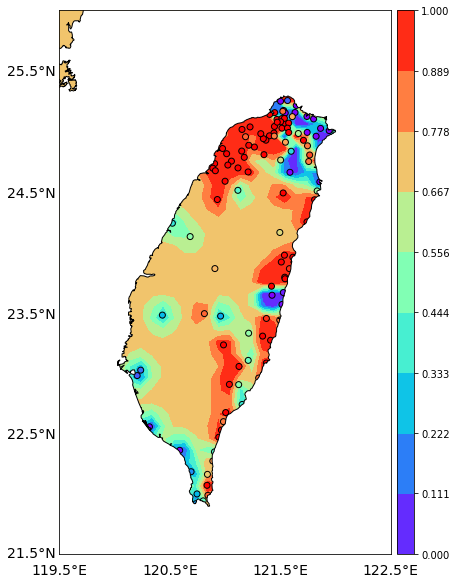

2010-02
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.130324141395
Full Sill: 0.188778197432
Range: 0.891774273794
Nugget: 0.0584540560371 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



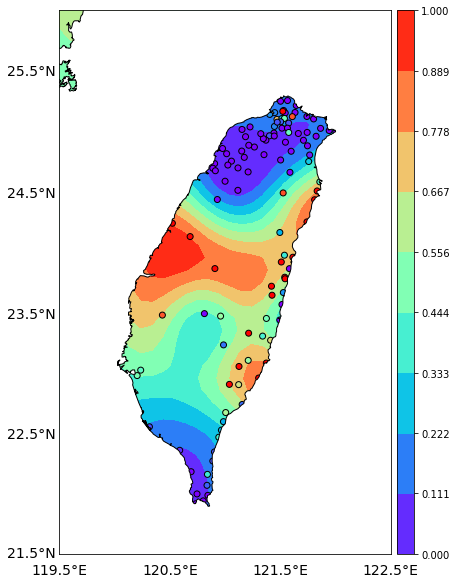

2010-03
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.114407205086
Full Sill: 0.162039059889
Range: 1.46926166853
Nugget: 0.0476318548033 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



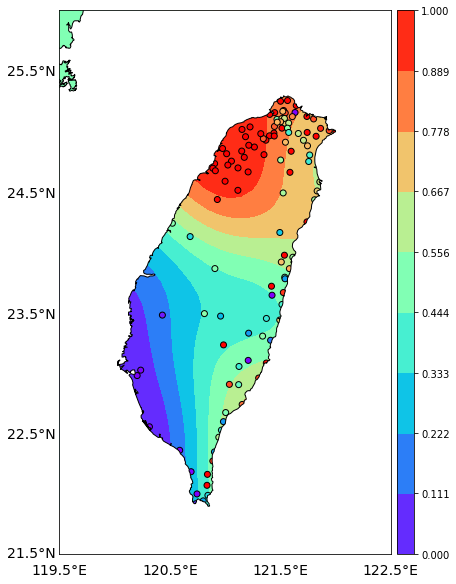

2010-04
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.104118679648
Full Sill: 0.236539857615
Range: 4.32123717297
Nugget: 0.132421177967 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



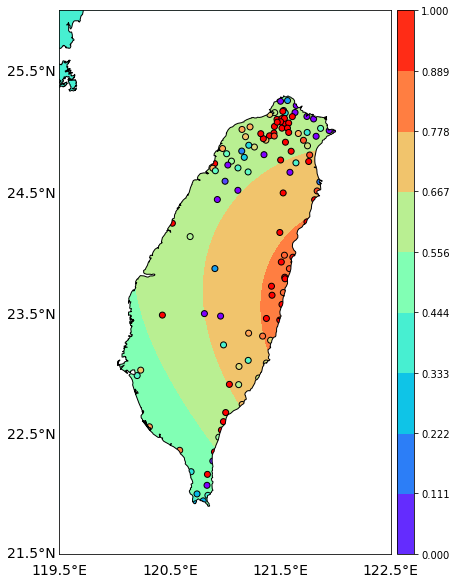

2010-05
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.14155870852
Full Sill: 0.220458820221
Range: 0.747030610913
Nugget: 0.0789001117008 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



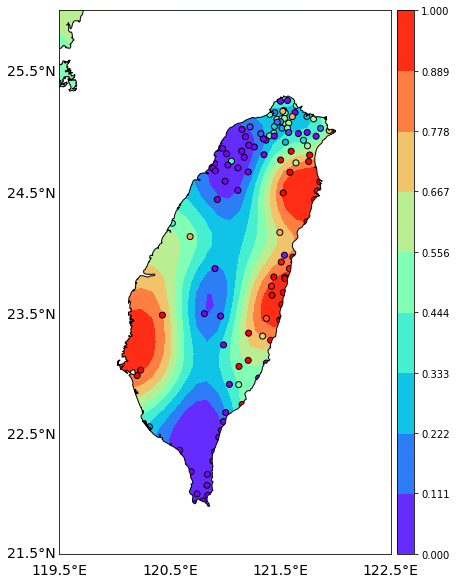

2010-06
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.242114440648
Full Sill: 0.242114440648
Range: 1.31431917821
Nugget: 5.38646780005e-18 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



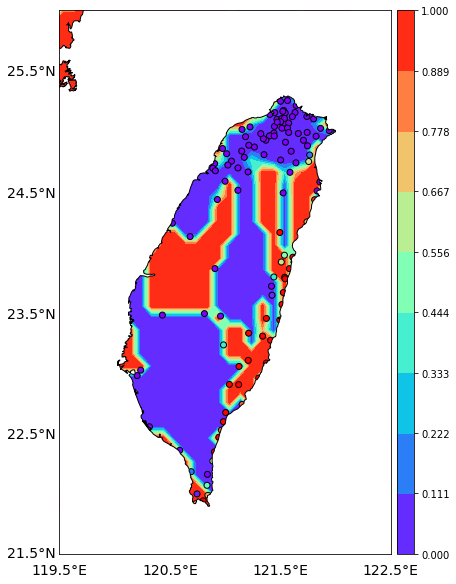

2010-07
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.0475909227069
Full Sill: 0.184813721391
Range: 0.880855741159
Nugget: 0.137222798684 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



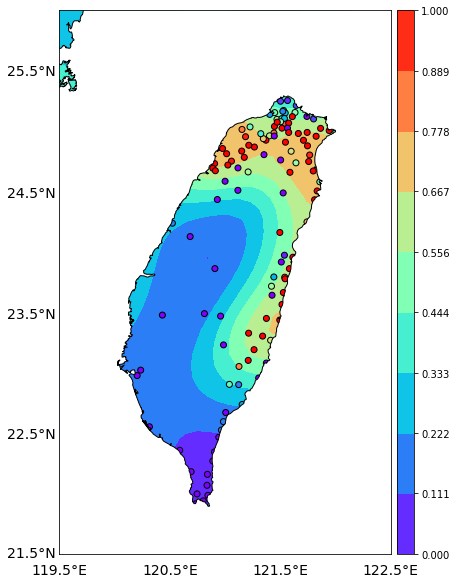

2010-08
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.122753893891
Full Sill: 0.160260225299
Range: 0.569670349893
Nugget: 0.0375063314079 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



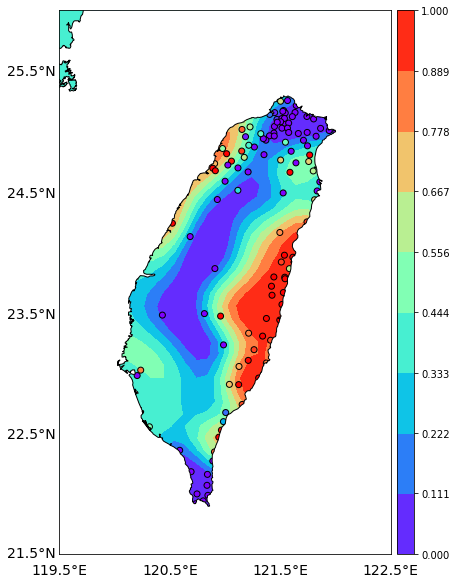

2010-09
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.288714591878
Full Sill: 0.374870372969
Range: 4.32123717297
Nugget: 0.0861557810914 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



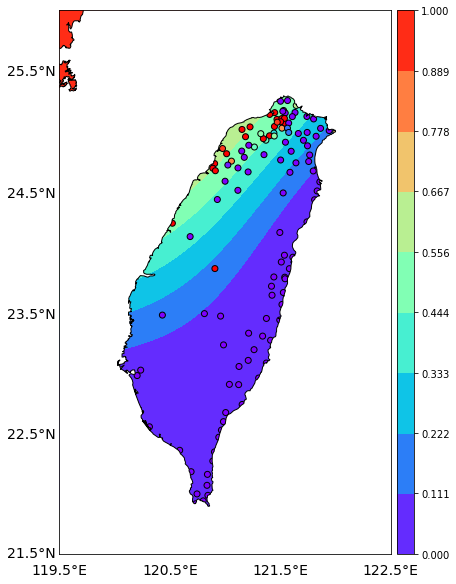

2010-10
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.176914058728
Full Sill: 0.182342816288
Range: 0.702167439996
Nugget: 0.00542875755973 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



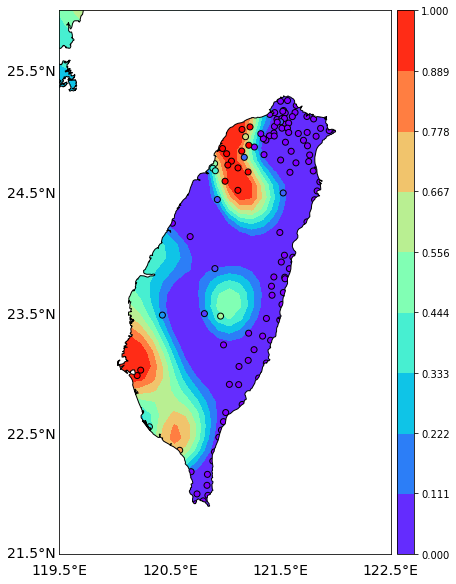

2010-11
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.139290773916
Full Sill: 0.139290774045
Range: 0.21586238916
Nugget: 1.28670088695e-10 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



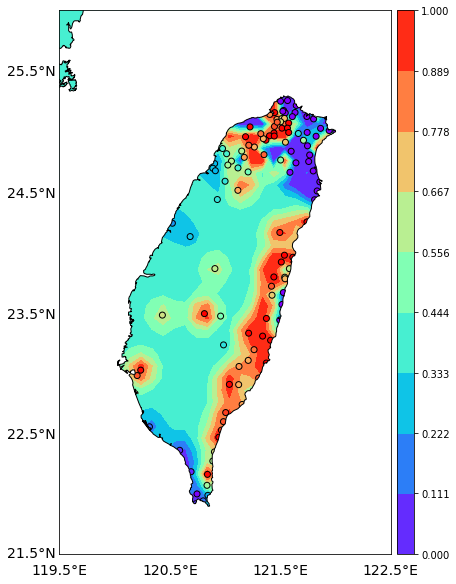

2010-12
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.167345859446
Full Sill: 0.167345859446
Range: 0.224938414544
Nugget: 9.47484368914e-14 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



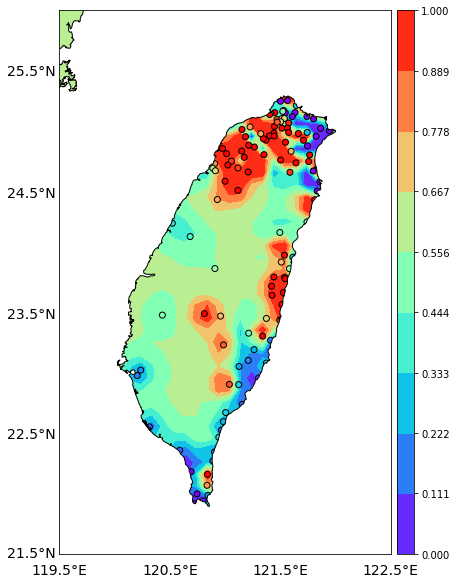

2011-01
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.163287126419
Full Sill: 0.163287126419
Range: 0.202323084827
Nugget: 2.59168098913e-14 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



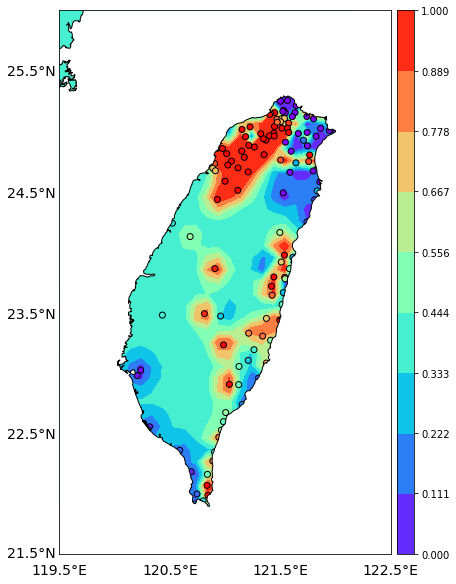

2011-02
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.0749182750797
Full Sill: 0.143689270812
Range: 0.453652506277
Nugget: 0.0687709957321 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



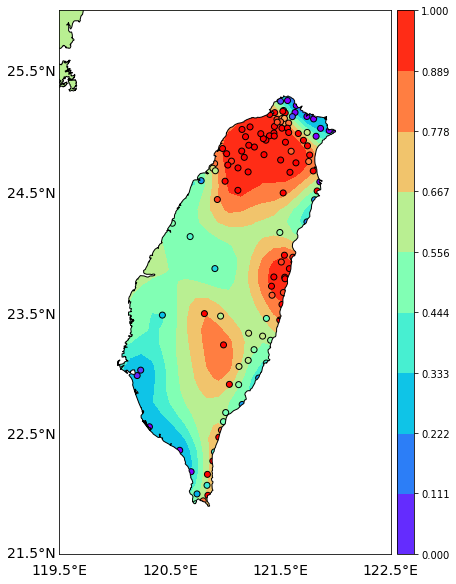

2011-03
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.0802350277577
Full Sill: 0.173784901802
Range: 0.398139815448
Nugget: 0.0935498740444 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



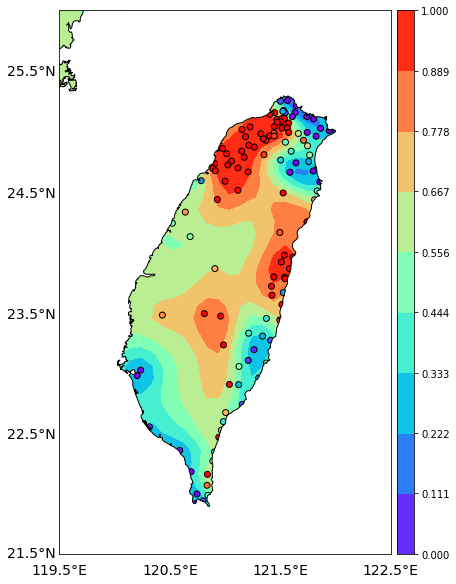

2011-04
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.0564246520446
Full Sill: 0.098563481344
Range: 0.871616195063
Nugget: 0.0421388292994 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



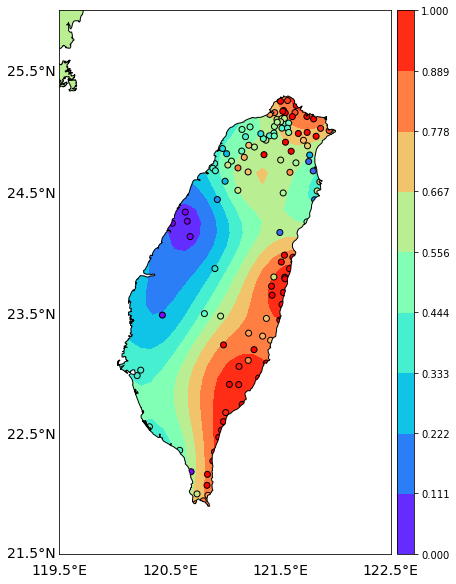

2011-05
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.256763154234
Full Sill: 0.306040077898
Range: 4.32123717297
Nugget: 0.0492769236635 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



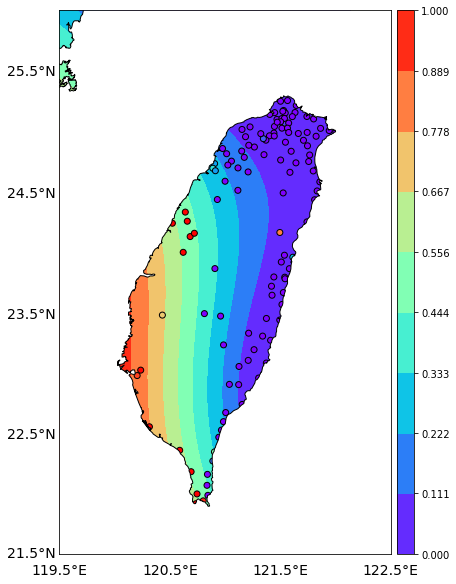

2011-06
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.203840781739
Full Sill: 0.222737018467
Range: 0.864609337586
Nugget: 0.0188962367277 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



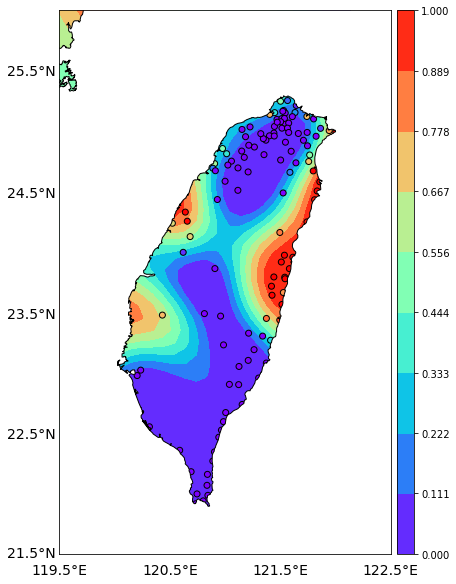

2011-07
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.110697898249
Full Sill: 0.213056526606
Range: 0.706451380496
Nugget: 0.102358628357 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



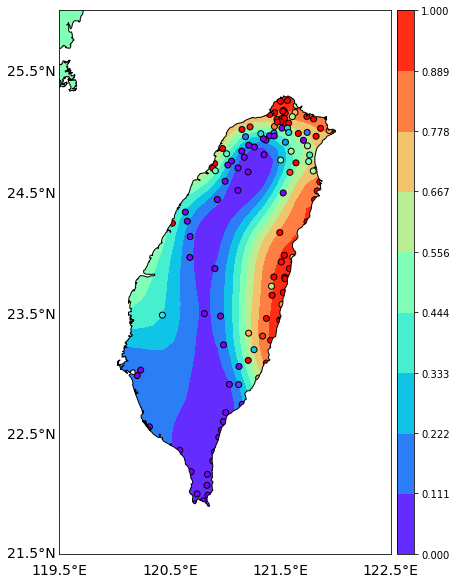

2011-08
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.254036268896
Full Sill: 0.350167463902
Range: 4.32123717297
Nugget: 0.0961311950057 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



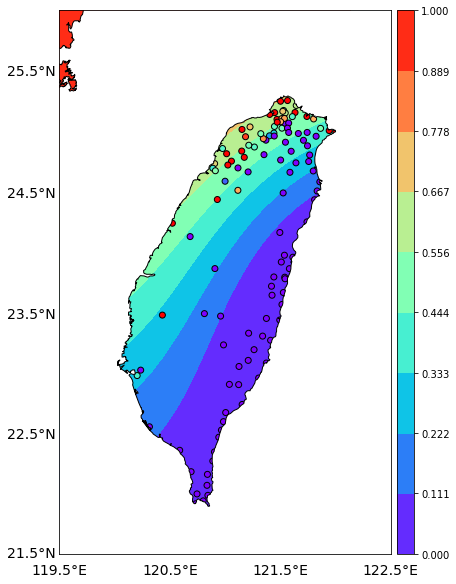

2011-09
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.0371683075316
Full Sill: 0.150485314028
Range: 1.23434751132
Nugget: 0.113317006496 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



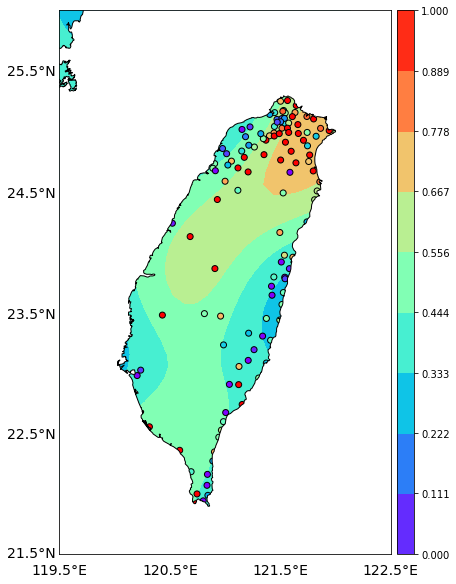

2011-10
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.112109702786
Full Sill: 0.188451339928
Range: 0.394191531105
Nugget: 0.0763416371421 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



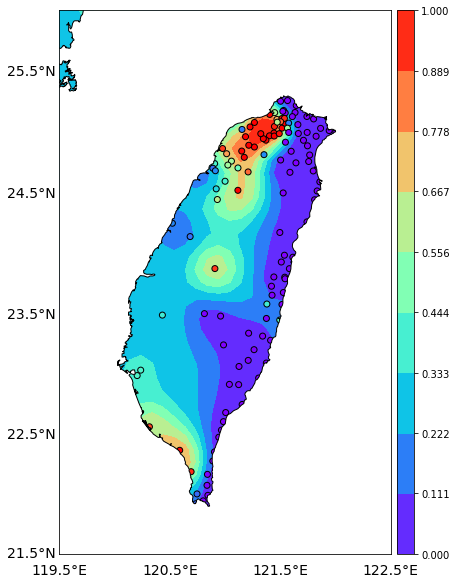

2011-11
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.103254421012
Full Sill: 0.122315416399
Range: 1.14585901655
Nugget: 0.0190609953871 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



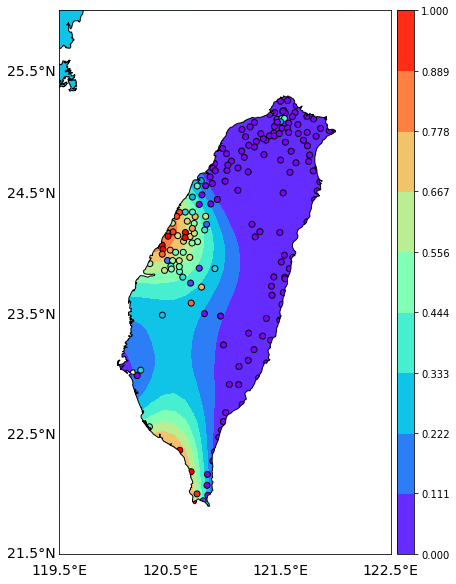

2011-12
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.0925316196647
Full Sill: 0.160232300634
Range: 0.654539440036
Nugget: 0.0677006809695 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



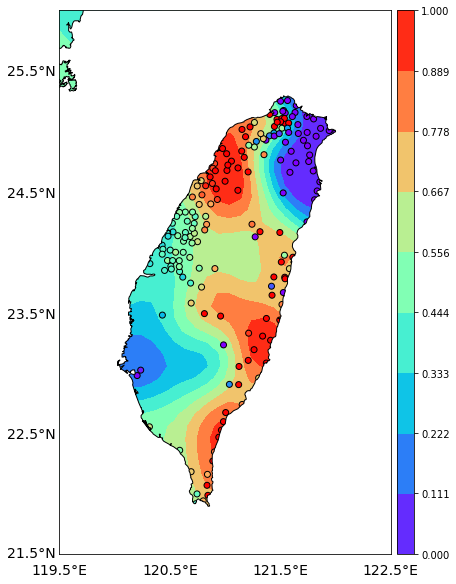

2012-01
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.067474422781
Full Sill: 0.148112597231
Range: 0.87134117351
Nugget: 0.0806381744505 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



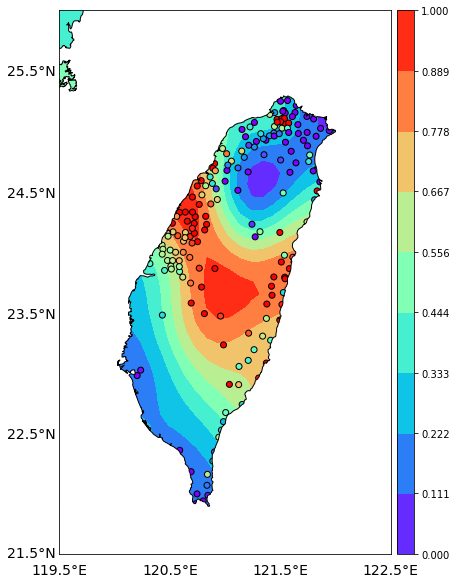

2012-02
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.243026968694
Full Sill: 0.249448999224
Range: 1.09650689164
Nugget: 0.0064220305302 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



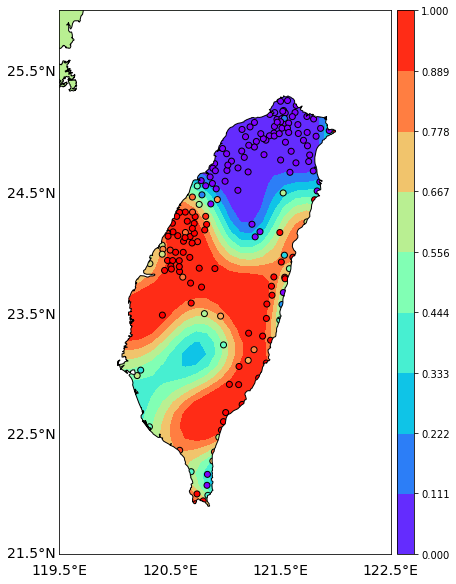

2012-03
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.130629000118
Full Sill: 0.232131116498
Range: 4.32123717297
Nugget: 0.10150211638 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



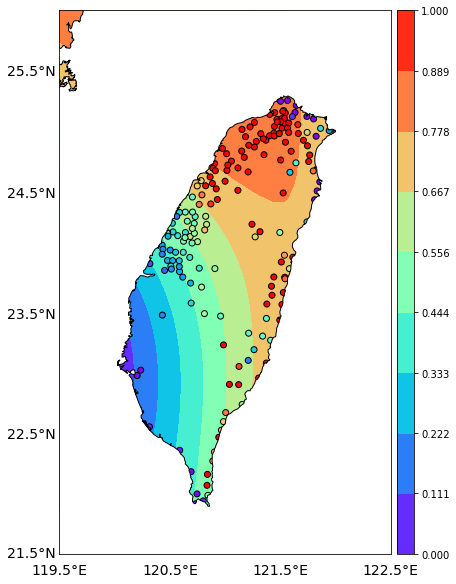

2012-04
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.288070069986
Full Sill: 0.323872902551
Range: 2.36109593153
Nugget: 0.0358028325649 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



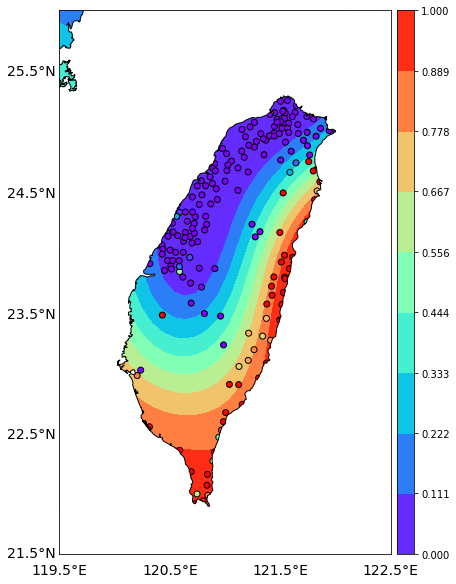

2012-05
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.124398292415
Full Sill: 0.154256035586
Range: 4.32123717297
Nugget: 0.0298577431706 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



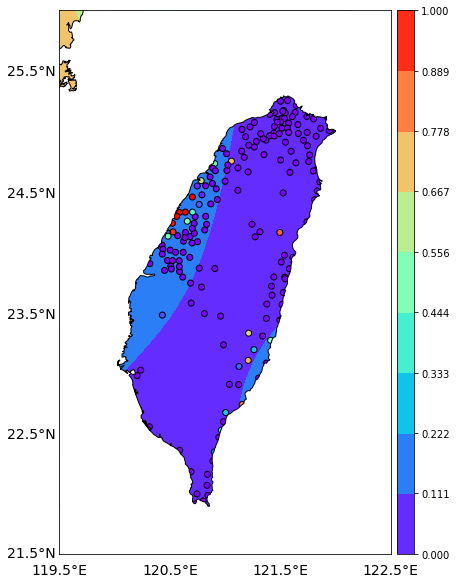

2012-06
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.100028711469
Full Sill: 0.100028711469
Range: 4.32123717297
Nugget: 6.2675062322e-21 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



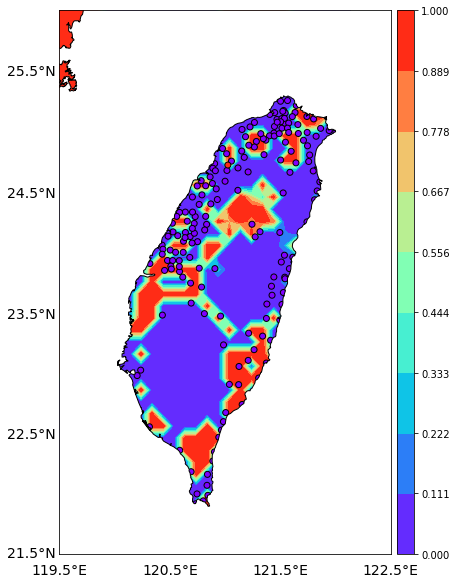

2012-07
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.0922122356081
Full Sill: 0.220470149314
Range: 2.04346069181
Nugget: 0.128257913705 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



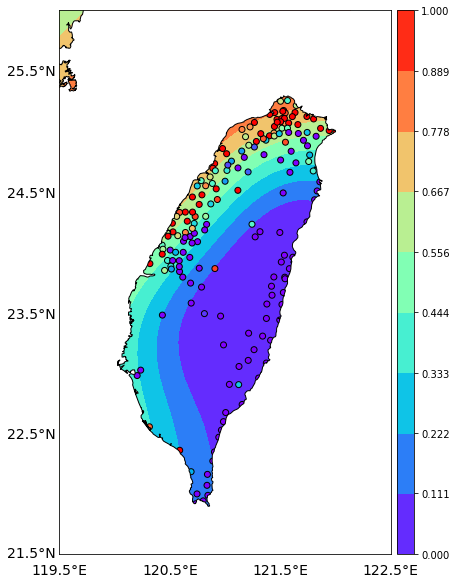

2012-08
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.053254733352
Full Sill: 0.053254733352
Range: 3.3887606533
Nugget: 2.5561714348e-22 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



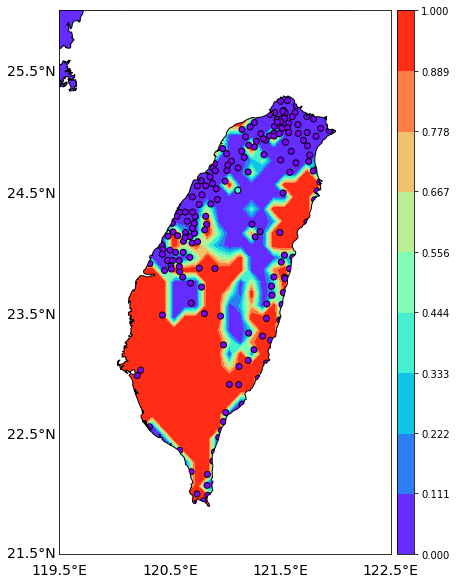

2012-09
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.142567458208
Full Sill: 0.167718282957
Range: 0.171297652734
Nugget: 0.0251508247491 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



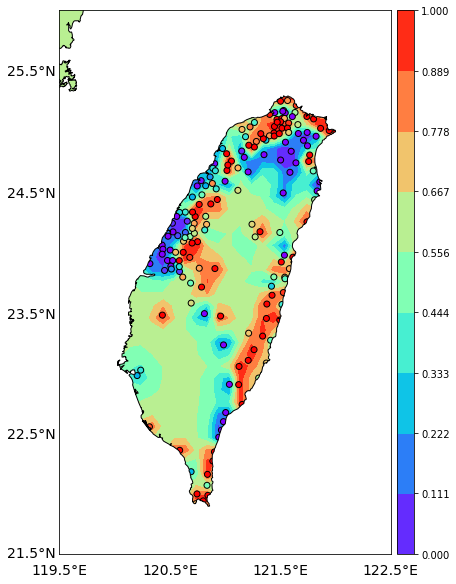

2012-10
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.143912095437
Full Sill: 0.190537328852
Range: 0.915456871542
Nugget: 0.0466252334152 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



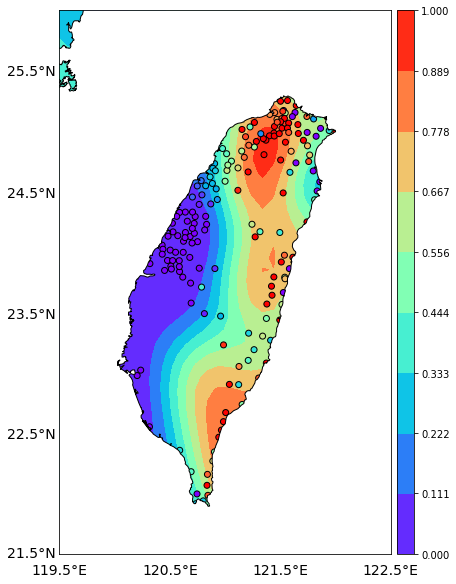

2012-11
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.221213095088
Full Sill: 0.271170455411
Range: 1.32683424703
Nugget: 0.0499573603229 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



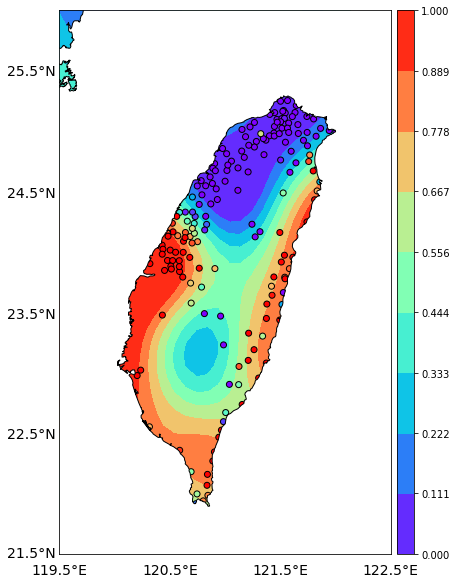

2012-12
Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 0.201763348406
Full Sill: 0.249589056445
Range: 1.08802958837
Nugget: 0.0478257080393 

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [ ]:
if __name__ == '__main__':

    main()
